#### Files
##### train.csv
* building_id - Foreign key for the building metadata.
* meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* timestamp - When the measurement was taken
* meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

##### building_meta.csv
* site_id - Foreign key for the weather files.
* building_id - Foreign key for training.csv
* primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* square_feet - Gross floor area of the building
* year_built - Year building was opened
* floor_count - Number of floors of the building

##### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

* site_id
* air_temperature - Degrees Celsius
* cloud_coverage - Portion of the sky covered in clouds, in oktas
* dew_temperature - Degrees Celsius
* precip_depth_1_hr - Millimeters
* sea_level_pressure - Millibar/hectopascals
* wind_direction - Compass direction (0-360)
* wind_speed - Meters per second

##### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.
* row_id - Row id for your submission file
* building_id - Building id code
* meter - The meter id code
* timestamp - Timestamps for the test data period



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df



In [3]:
df_train = pd.read_csv("datasets/train_merge.csv")

In [4]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 963.98 Mb (63.2% reduction)


In [5]:
df_train.shape

(20216100, 17)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 17 columns):
Unnamed: 0            int32
building_id           int16
meter                 int8
timestamp             object
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: float16(9), float32(1), int16(1), int32(2), int8(2), object(2)
memory usage: 964.0+ MB


In [9]:
df_train.head()

,Unnamed: 0,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [6]:
df_train.isnull().sum(axis = 0)

Unnamed: 0                   0
building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [22]:
# print(df_train['wind_speed'].unique())
# print(df_train['wind_speed'].value_counts())

In [23]:
# nan_values={'air_temperature':np.around(np.mean(df_train['air_temperature']),decimals=1),'cloud_coverage':np.around(np.mean(df_train['cloud_coverage'])),'dew_temperature':np.around(np.mean(df_train['dew_temperature']),decimals=1),'precip_depth_1_hr':np.around(np.mean(df_train['precip_depth_1_hr'])),'sea_level_pressure':np.around(np.mean(df_train['sea_level_pressure'])),'wind_direction':np.around(np.mean(df_train['wind_direction'])),'wind_speed':np.around(np.mean(df_train['wind_speed']))}
# df_train=df_train.fillna(value=nan_values)

In [24]:
df_train.isnull().sum(axis = 0)

Unnamed: 0                   0
building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built            12127645
floor_count           16709167
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
dtype: int64

In [25]:
print(df_train['meter'].unique())
df_train['meter'].value_counts()

[0 3 1 2]


0    12060910
1     4182440
2     2708713
3     1264037
Name: meter, dtype: int64

0    59.659925
1    20.688659
2    13.398791
3     6.252625
Name: meter, dtype: float64


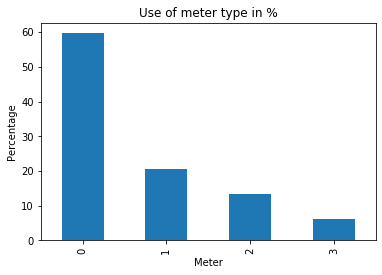

In [26]:
meter_percent = df_train.meter.value_counts('percent')*100
print(meter_percent)
meter_percent.plot(kind='bar')
plt.title("Use of meter type in %")
plt.ylabel("Percentage")
plt.xlabel("Meter")
plt.show()

In [27]:
print(df_train['site_id'].unique())
df_train['site_id'].value_counts()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


13    2711763
9     2679323
2     2530312
14    2501506
3     2370097
15    1815054
0     1076662
5      781776
4      746746
6      668133
8      567915
1      553357
10     411407
7      366681
12     315909
11     119459
Name: site_id, dtype: int64

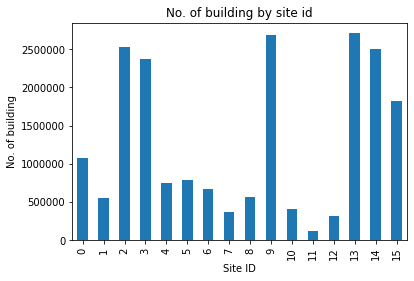

In [28]:
df_train.groupby('site_id')['building_id'].count().plot(kind='bar')
plt.title("No. of building by site id")
plt.ylabel("No. of building")
plt.xlabel("Site ID")
plt.show()

['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']
Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64


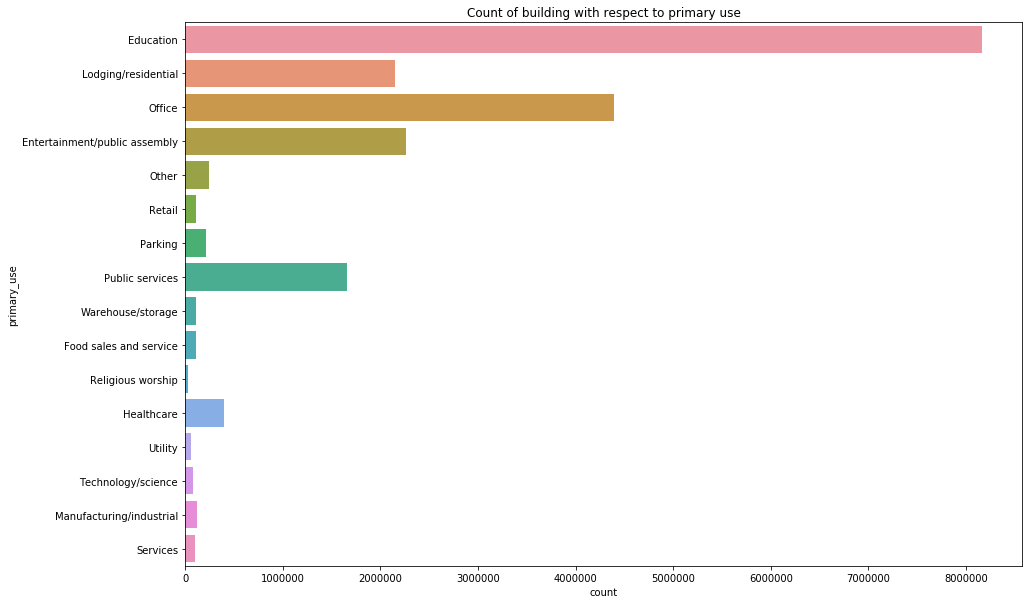

In [35]:
print(df_train['primary_use'].unique())
print(df_train['primary_use'].value_counts())
plt.figure(figsize=(15,10))
sns.countplot(y='primary_use',data=df_train)
plt.title("Count of building with respect to primary use")
plt.show()

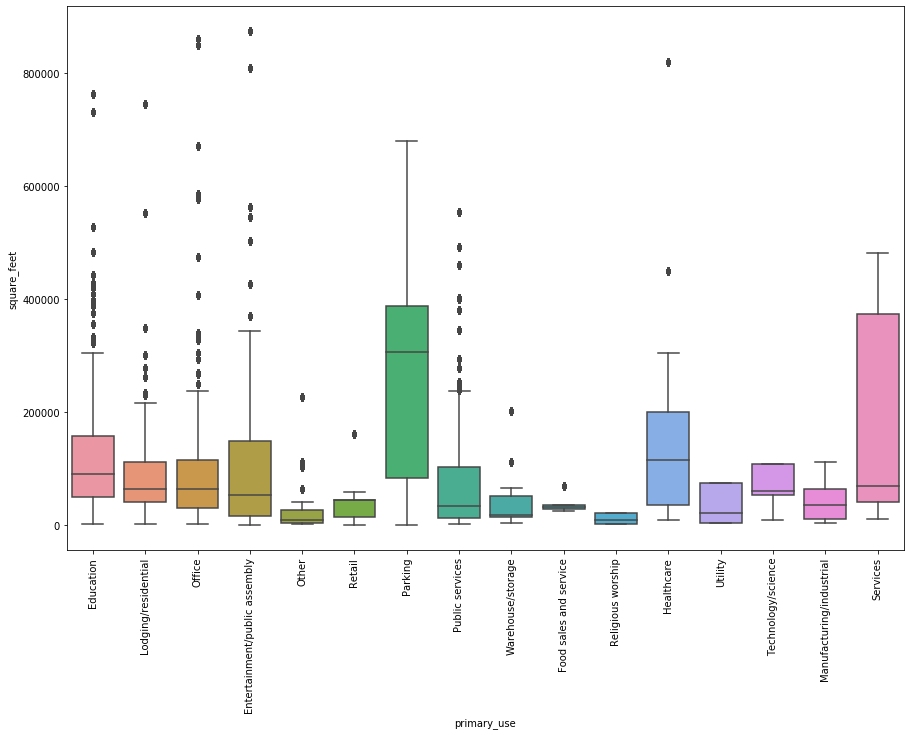

In [34]:
plt.figure(figsize=(15,10))
sns.boxplot(x='primary_use', y='square_feet', data=df_train)
plt.xticks(rotation=90)
plt.show()

[2008. 2004. 1991. 2002. 1975. 2000. 1981. 1989. 2003. 2010. 1968. 1999.
 2013. 1974. 1996. 1980. 1977. 1990. 1985. 2001. 1969. 2005. 2016. 2014.
 1970. 1971. 2011. 1997. 2007. 1998. 2009. 1979. 1986. 2006. 1982. 1983.
   nan 1913. 1953. 1909. 1958. 1960. 1976. 1906. 1900. 1995. 1956. 1930.
 1967. 1919. 1955. 1965. 1907. 2012. 1992. 1948. 1950. 1941. 1957. 1964.
 1940. 1951. 1966. 1934. 1959. 1993. 1939. 1918. 1963. 1987. 1914. 1973.
 1988. 1935. 1942. 2015. 1931. 1928. 1929. 1908. 1927. 1923. 1962. 1944.
 1910. 1949. 2017. 1922. 1911. 1932. 1978. 1912. 1916. 1924. 1926. 1904.
 1984. 1903. 1925. 1961. 1921. 1972. 1936. 1954. 1905. 1920. 1917. 1952.
 1994. 1933. 1945. 1938. 1915. 1947. 1946. 1902. 1937.]
1976.0    531091
1964.0    260737
1966.0    228062
2006.0    194814
1968.0    187867
           ...  
1918.0      8782
1926.0      8782
1936.0      8782
1944.0      8779
1972.0      8518
Name: year_built, Length: 116, dtype: int64


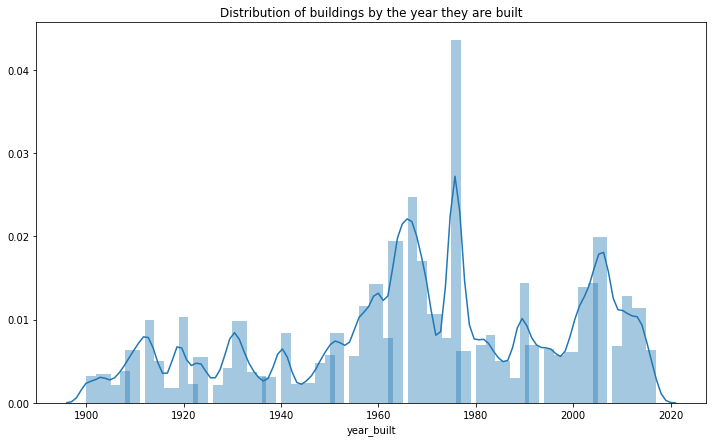

In [38]:
print(df_train['year_built'].unique())
print(df_train['year_built'].value_counts())
plt.figure(figsize=(12,7))
sns.distplot(df_train['year_built'].dropna())
plt.title('Distribution of buildings by the year they are built')
plt.show()

/home/jakesh/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/jakesh/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


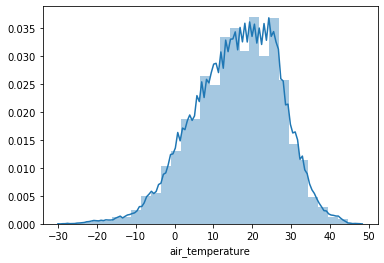

In [39]:
sns.distplot(df_train['air_temperature'], hist=True, kde=True,bins=30)

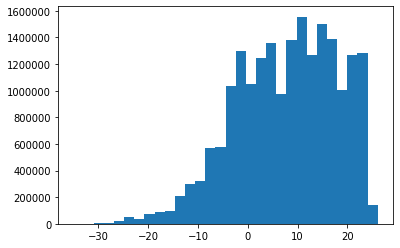

In [40]:
plt.hist(df_train['dew_temperature'], bins=30)
plt.show()

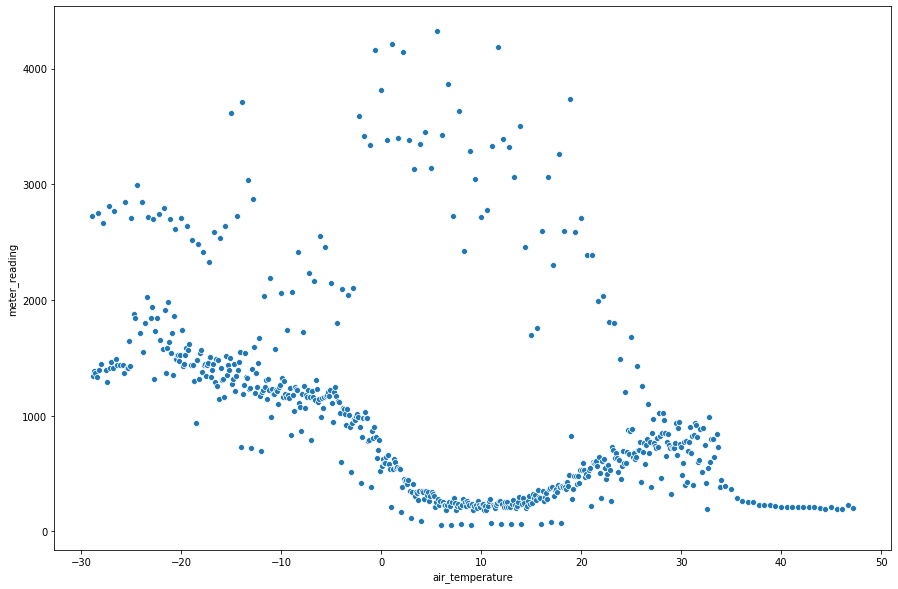

In [42]:
m_a=df_train.groupby('air_temperature')['meter_reading'].mean().to_frame()
plt.figure(figsize=(15,10))
sns.scatterplot(m_a.index,m_a['meter_reading'])

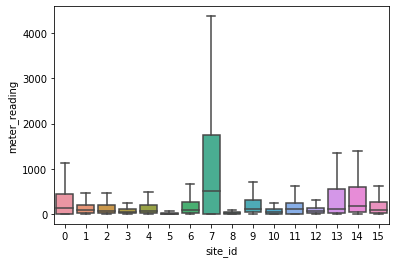

In [44]:
sns.boxplot(df_train['site_id'], df_train['meter_reading'], showfliers=False)

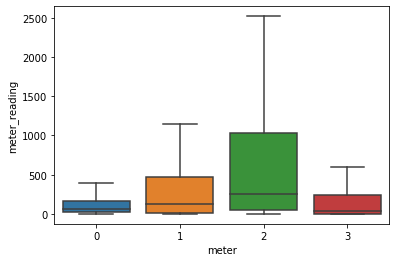

In [45]:
sns.boxplot(df_train['meter'], df_train['meter_reading'], showfliers=False)

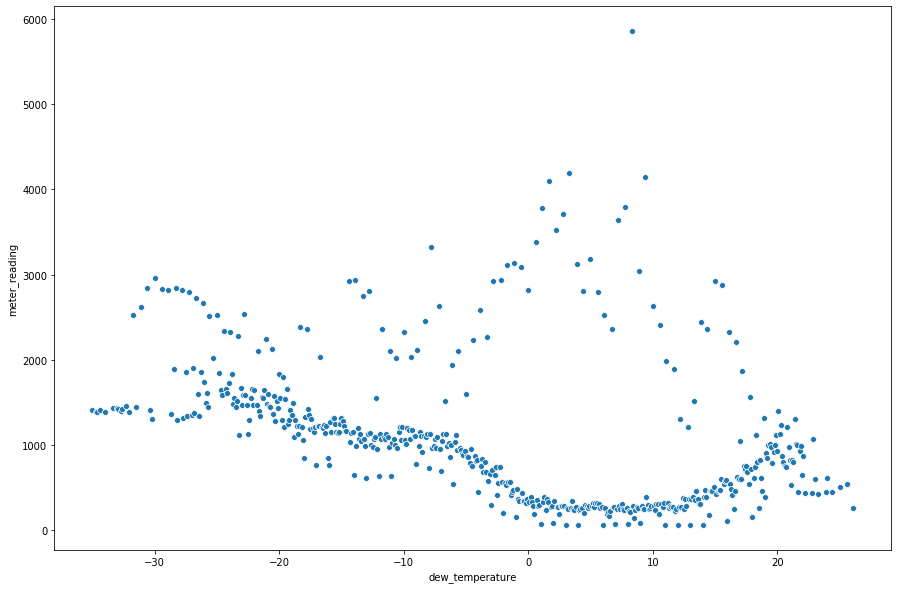

In [46]:
m_d=df_train.groupby('dew_temperature')['meter_reading'].mean().to_frame()
plt.figure(figsize=(15,10))
sns.scatterplot(m_d.index,m_d['meter_reading'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

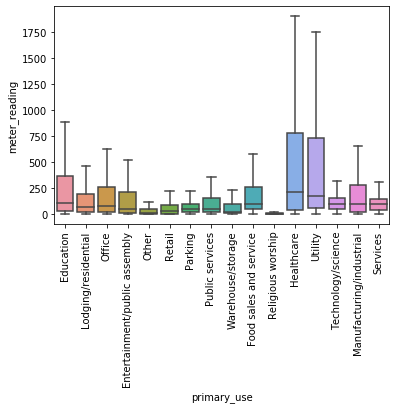

In [47]:
sns.boxplot(df_train['primary_use'], df_train['meter_reading'], showfliers=False)
plt.xticks(rotation=90)

In [1]:
drop_cols = ["precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed","year_built","Unnamed: 0","year_built","floor_count"]


In [2]:
df_train = df_train.drop(drop_cols, axis = 1)

NameError: name 'df_test' is not defined

In [ ]:
df_train.to_csv("datasets/ashrae-energy-prediction/train_final.csv")